Text(0.5, 1.0, 'KEGG reactions')

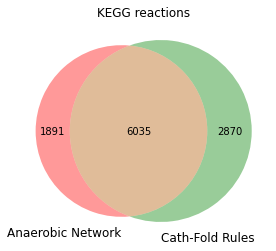

In [1]:
import networkExpansionPy.lib as ne
from scipy.sparse import csr_matrix
import numpy as np
from random import sample
import pandas as pd

#from copy import copy, deepcopy
import random
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

metabolism = ne.GlobalMetabolicNetwork()
#metabolism.pruneUnbalancedReactions()
#metabolism.pruneInconsistentReactions()
#metabolism.set_ph(7.0)
metabolism.convertToIrreversible()

oxygen_dependent_rxns = metabolism.network[metabolism.network.cid.isin(['C00007'])].rn.unique().tolist()
o2_independent_rxns = [x for x in metabolism.network.rn.unique().tolist() if x not in oxygen_dependent_rxns]

# only keep anaerobic reactions
metabolism.subnetwork(o2_independent_rxns)
#metabolism.setMetaboliteBounds(ub=1e-1,lb=1e-6)
#metabolism.pruneThermodynamicallyInfeasibleReactions(keepnan=False)

# define seed compounds
cpds = pd.read_csv('/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/assets/compounds/seeds.csv')
cpds['CID'] = cpds['CID'].apply(lambda x: x.strip())
seed_set = cpds['CID'].unique().tolist()


rules = pd.read_csv('/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/assets/ecode/cath_code_rule.keggRxn.Jan2020.csv')
rns = rules.rn.unique().tolist()

grxns = set(metabolism.network.rn.unique().tolist())
frxns = set(rns)
subsets = (len(grxns - frxns), len(frxns - grxns), len(grxns.intersection(frxns)))

venn2(subsets = subsets,set_labels={'Anaerobic Network','Cath-Fold Rules'})
plt.title('KEGG reactions')

In [2]:
m = metabolism.copy()

In [3]:
# compare reactions vs. naive algorithm
ne_cpds_naive,ne_rxns_naive = m.expand(seed_set,algorithm='naive')
ne_cpds_cr,ne_rxns_cr = m.expand(seed_set,algorithm='cr')

/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:206: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp_cr(R,P,x0,b)


In [8]:
codes =  rules['cath_code_rule'].apply(lambda x: set(x.split('_')))
rules['cath_sets']= rules['cath_code_rule'].apply(lambda x: set(x.split('_')))

cath_codes = [item for sublist in codes for item in sublist]
cath_codes = list(set(cath_codes))

def rule2rn(foldSet,x):
    if x.issubset(foldSet):
        return True
    else:
        return False
    
def folds2rn(rules_sub,foldSet):
    rules_sub['rn_feasible'] = rules_sub['cath_sets'].apply(lambda x: rule2rn(foldSet,x))
    rns = rules_sub[rules_sub['rn_feasible']].rn.tolist()
    return rns

In [170]:
def iterative_fold_expansion(metabolism,codes,fold_set,cpd_set,rxn_set):
    cpd_dict = {}
    fold_dict = {}
    rn_expanded = {}
    rn_feasible = {}
    
    for code in codes:
        fold_set_j = fold_set.union(set([code]))
        
        fold_dict[code] = fold_set_j
        
        rxns = folds2rn(rules,fold_set_j)
        
      
        # only keep reactions
        rxns = rxns + list(rxn_set)  
        # determine if the same reaction set was used previously
        matched_codes = [x for x,y in rn_feasible.items() if set(rxns) == y]
        if len(matched_codes) < 1:
            # perform expansion step
            m = metabolism.copy()
            rn_feasible[code] = set(rxns)
            m.subnetwork(rxns)
            #rn_dict[code] = rxns
            if len(m.network) > 0:
                cpds,rxns_new = m.expand(list(cpd_set))
                cpd_set_new = cpd_set.union(set(cpds))
                cpd_dict[code] = cpd_set_new
                rn_expanded[code] = set(rxns_new)

            else:
                cpd_dict[code] = cpd_set
                rn_expanded[code] = set()
        else:
            # copy expansion step from other code
            c = matched_codes[0]
            rn_feasible[code] = rn_feasible[c]
            cpd_dict[code] = cpd_dict[c]
            rn_expanded[code] = rn_expanded[c]
            
    return cpd_dict,fold_dict,rn_expanded,rn_feasible

def optimal_code_order(metabolism,folds,cpd_set,rn_set):
    fold_set = set()
    #cpd_set = set(seed_set)
    #rn_set = rxn_set
    seed_set = cpd_set.copy()
    rn_set_initial = rn_set.copy()
    code_remain = folds[:]
    code_order = []
    compound_order = []
    rn_order = [];
    
    while len(code_remain) > 0:
        
        cpd_dict,fold_dict,rn_dict,rn_feas = iterative_fold_expansion(metabolism,code_remain,fold_set,cpd_set,rn_set)
        rn_nums = np.array([len(y) for x,y in rn_dict.items()])
        
        idxs = np.argwhere(rn_nums == rn_nums.max()).T[0]
        if len(idxs) > 1:
            # find equal codes with same size
            eq_codes = [list(rn_dict)[i] for i in idxs]
            # among these codes, choose largest compound network
            cnums = np.array([len(cpd_dict[x]) for x in eq_codes])
            jdxs = np.argwhere(cnums == cnums.max()).T[0]
            idxs = [idxs[j] for j in jdxs]
            if len(idxs) > 1:
                # just sample 1 if completely equal
                idxs = random.sample(idxs,1)
        
        max_idx = idxs[0]
        #max_idx = rn_nums.argmax()
        new_code = code_remain[max_idx]
        code_order.append(new_code)

        # add to growing fold set
        fold_set = fold_set.union(set([new_code]))
        code_remain = [x for x in code_remain if x not in list(fold_set)]
        compound_order.append(cpd_dict[new_code])
        rn_order.append(rn_dict[new_code])
        
        # add to growing compound, reaction set
        cpd_set = cpd_set.union(set(cpd_dict[new_code]))
        rn_set = rn_set.union(set(rn_dict[new_code]))
    
    # generate a table with a simple network size
    
    rtab = pd.DataFrame({'iteration': range(0,len(code_order)+1), 'fold': ['None'] + code_order, 'cpd_num': [len(seed_set)] + [len(x) for x in compound_order], 'rxn_num': [0] + [len(x) for x in rn_order]})
    # generate a table with the compounds at each iteration
    cpdo = [seed_set] + compound_order
    unique_items = lambda t: list(set([item for sublist in t for item in sublist]))
    find_cpd_iter = lambda c: np.where(np.array([c in x for x in cpdo]))[0].min()
    cpds = unique_items(compound_order)
    cpds_iter = [find_cpd_iter(x) for x in cpds]
    cpd_df = pd.DataFrame({'cid': cpds, 'iter': cpds_iter}).sort_values('iter').set_index('cid').join(metabolism.compounds.set_index('cid'))

    # perform same step for reactions
    rpdo = [rn_set_initial] + rn_order
    unique_items = lambda t: list(set([item for sublist in t for item in sublist]))
    find_rpd_iter = lambda c: np.where(np.array([c in x for x in rpdo]))[0].min()
    rns = unique_items(rn_order)
    rns_iter = [find_rpd_iter(x) for x in rns]
    rn_df = pd.DataFrame({'rxn': rns, 'iter': rns_iter}).sort_values('iter').set_index('rxn')
    
    results = {}
    results['networkSize'] = rtab
    results['compoundTable'] = cpd_df
    results['reactionTable'] = rn_df
    return results
    #return code_order,compound_order,rn_order


In [135]:
seed = set(seed_set)
code_order_v1,cpd_order_v1,rn_order_v1 = optimal_code_order(metabolism,cath_codes,seed,set())


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is 

In [160]:
code_order,compound_order,rn_order = code_order_v1,cpd_order_v1,rn_order_v1


In [162]:
code_order,compound_order,rn_order = code_order_v1,cpd_order_v1,rn_order_v1

rn_set_initial = set()

rtab = pd.DataFrame({'iteration': range(0,len(code_order)+1), 'fold': ['None'] + code_order_v1, 'cpd_num': [len(seed_set)] + [len(x) for x in compound_order], 'rxn_num': [0] + [len(x) for x in rn_order]})
# generate a table with the compounds at each iteration
cpdo = [seed_set] + compound_order
unique_items = lambda t: list(set([item for sublist in t for item in sublist]))
find_cpd_iter = lambda c: np.where(np.array([c in x for x in cpdo]))[0].min()
cpds = unique_items(compound_order)
cpds_iter = [find_cpd_iter(x) for x in cpds]
cpd_df = pd.DataFrame({'cid': cpds, 'iter': cpds_iter}).sort_values('iter').set_index('cid').join(metabolism.compounds.set_index('cid'))

# perform same step for reactions
rpdo = [rn_set_initial] + rn_order
unique_items = lambda t: list(set([item for sublist in t for item in sublist]))
find_rpd_iter = lambda c: np.where(np.array([c in x for x in rpdo]))[0].min()
rns = unique_items(rn_order)
rns_iter = [find_rpd_iter(x) for x in rns]
rn_df = pd.DataFrame({'rxn': rns, 'iter': rns_iter}).sort_values('iter').set_index('rxn')


In [165]:
results = {}
results['networkSize'] = rtab
results['compoundTable'] = cpd_df
results['reactionTable'] = rn_df

In [167]:
# save files
results['networkSize'].to_csv('foldExpansion.rxnNumCriteria.27Jan21.FoldOrderTable.tab',sep='\t')
results['compoundTable'].to_csv('foldExpansion.rxnNumCriteria.27Jan21.compoundTable.tab',sep='\t')
results['reactionTable'].to_csv('foldExpansion.rxnNumCriteria.27Jan21.reactionTable.tab',sep='\t')

In [171]:
# define results when adding reactions from subset not covered by CATH database
rxn_invar = grxns - frxns
seed = set(seed_set)
results_v2 = optimal_code_order(metabolism,cath_codes,seed,rxn_invar)

/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:204: SparseEfficiencyWarning: Comparing sparse matrices using == is 

In [173]:
results_v2['networkSize'].to_csv('foldExpansion.rxnNumCriteria.RxnInvaiant.27Jan21.FoldOrderTable.tab',sep='\t')
results_v2['compoundTable'].to_csv('foldExpansion.rxnNumCriteria.RxnInvaiant.27Jan21.compoundTable.tab',sep='\t')
results_v2['reactionTable'].to_csv('foldExpansion.rxnNumCriteria.RxnInvaiant.27Jan21.reactionTable.tab',sep='\t')

In [175]:
results['networkSize']

,iteration,fold,cpd_num,rxn_num
0,0,None,44,0
1,1,3.40,922,2592
2,2,3.30,945,2664
3,3,3.20,960,2694
4,4,3.75,964,2706
5,5,1.10,967,2714
6,6,3.60,969,2720
7,7,3.90,969,2722
8,8,2.160,969,2722
9,9,1.20,969,2722


In [176]:
results_v2['networkSize']

,iteration,fold,cpd_num,rxn_num
0,0,None,44,0
1,1,3.40,2934,8352
2,2,3.20,3011,8602
3,3,3.30,3028,8682
4,4,3.60,3034,8714
5,5,1.10,3039,8740
6,6,3.75,3048,8762
7,7,3.90,3049,8766
8,8,2.40,3049,8770
9,9,6.20,3049,8770


In [ ]:
def compute_random_compound_fe(folds):
    fold_set = set()
    cpd_sets = []
    cpd_set = set(seed_set)
    cpd_num = []

    for cath in folds:
        fold_set = fold_set.union(set([cath]))

        rxns = folds2rn(rules,fold_set)
        # prune network 
        m = metabolism.copy()
        # only keep reactions
        m.subnetwork(rxns)
        if len(m.network) > 0:
            cpds,rxns= m.expand(list(cpd_set))
            cpd_set = cpd_set.union(set(cpds))

        cpd_sets.append(cpd_set)
        #print('done with cath: ' + cath)
    return cpd_sets,rn_sets